# Optimal Learning Rate 찾기 및 Huber Loss 함수 적용

Huber 손실은 회귀 문제에 사용되는 손실 함수로, 평균 제곱 오차(Mean Squared Error, MSE)와 평균 절대 오차(Mean Absolute Error, MAE) 사이의 절충안입니다. Huber 손실은 예측 오차가 작은 경우에는 평균 제곱 오차 처럼 작동하고, 예측 오차가 큰 경우에는 평균 절대 오차처럼 작동합니다. 이러한 특성 때문에 Huber 손실은 이상치(outliers)에 대해 덜 민감하며, 이상치가 있는 데이터에 대한 회귀 문제에 적합합니다.

<img src="https://blog.kakaocdn.net/dn/081sh/btqNth1n6DL/rkSLdrV0RFuYg04k4VyeZK/img.png" width=300/>

$$L_{\delta}(y, f(x))= \begin{cases}
    \frac{1}{2}(y-f(x))^2       & \quad \text{ for |y-f(x)|} \leq \delta,\\
   \delta |y-f(x)|-\frac{1}{2} \delta^2  & \quad \text{if } n \text{ is odd}
  \end{cases}$$  
  
- Huber function은 모든 구간에서 미분가능하고 연속  
- $\delta$로 경사도 조절

Huber 손실은 사용자가 지정한 임계값(delta)을 기준으로 예측 오차의 크기에 따라 다른 방식으로 작동합니다.  
예측 오차가 임계값 이내인 경우: 제곱 오차 손실을 사용하여 손실을 계산합니다. 이 영역에서 Huber 손실은 이차 함수 형태를 가집니다.  
예측 오차가 임계값보다 큰 경우: 평균 절대 오차를 사용하여 손실을 계산합니다. 이 영역에서 Huber 손실은 선형 함수 형태를 가집니다.  
Huber 손실의 이러한 형태는 예측 오차가 작을 때는 예측이 민감하게 반응하도록 하고, 큰 오차가 발생할 때는 이상치의 영향을 줄이도록 돕습니다. 이렇게 함으로써, Huber 손실은 회귀 모델이 데이터의 전반적인 패턴을 더 잘 학습하도록 돕습니다.

### Sunspots 데이터셋을 활용하여 window_dataset 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
df = pd.read_csv(url, skiprows=0, index_col=0) # 첫 줄은 header이므로 skip 
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


- 시간 절약을 위해 최근 500 개월치 data 만 이용

In [2]:
time = df.iloc[-500:, 0].values
time_series = df.iloc[-500:, 1].values
time.shape, time_series.shape

((500,), (500,))

## Supervised Learning dataset 작성

windowed_dataset 함수는 주어진 시계열 데이터에 대해 지정된 윈도우 크기와 배치 크기를 사용하여 TensorFlow 데이터셋을 생성합니다. 이 함수는 다음 과정을 거칩니다.

1. tf.data.Dataset.from_tensor_slices(series)를 사용하여 시계열 데이터를 TensorFlow 데이터셋으로 변환합니다.  
2. ds.window(window_size+1, shift=1, drop_remainder=True)를 사용하여 데이터셋을 지정된 윈도우 크기로 나누고, 각 윈도우를 한 스텝씩 이동시킵니다. drop_remainder=True를 설정하면 남은 부분이 윈도우 크기보다 작을 경우 제거합니다.  
3. ds.flat_map(lambda w: w.batch(window_size+1))를 사용하여 각 윈도우를 하나의 배치로 합칩니다.  
4. ds.shuffle(shuffle_buffer)를 사용하여 데이터셋을 섞습니다. 이렇게 하면 훈련 중 모델이 더 잘 일반화됩니다.  
5. ds.map(lambda w: (w[:-1], w[-1]))를 사용하여 각 윈도우를 입력(X)과 출력(y)으로 분리합니다. 입력은 윈도우의 처음부터 끝에서 두 번째 요소까지이고, 출력은 윈도우의 마지막 요소입니다.  
6. ds.batch(batch_size).prefetch(1)를 사용하여 데이터셋을 지정된 배치 크기로 나누고, 다음 배치를 미리 준비하도록 설정합니다.

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

### train/validation set 분리

In [4]:
split_time = 450

time_train = time[:split_time]
time_test = time[split_time:]

X_train = time_series[:split_time]
X_test  = time_series[split_time:]

len(time_train), len(time_test), len(X_train), len(X_test)

(450, 50, 450, 50)

In [5]:
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

train_ds = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [6]:
for x, y in train_ds:
    print('x = ', x.numpy().shape)
    print('y = ', y.numpy().shape)
    break

x =  (16, 20)
y =  (16,)


## Stacked LSTM

In [7]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
        ])
    return model

### Optimal Learning Rate 찾기

다음 단계를 수행합니다:

LearningRateScheduler 콜백을 생성합니다. 이 콜백은 매 에포크마다 학습률을 조정하는 데 사용됩니다. 여기서는 학습률이 초기에 1e-8에서 시작하여 에포크마다 10^(epoch/20)씩 증가하도록 설정했습니다.  
SGD 옵티마이저를 생성하고 초기 학습률과 모멘텀을 설정합니다. 초기 학습률은 1e-8로 설정하고 모멘텀은 0.9로 설정했습니다.  
모델을 컴파일합니다. 손실 함수로 Huber 손실을 사용하고, 앞서 생성한 옵티마이저를 사용하여 모델을 최적화합니다. 또한, 훈련 과정에서 평균 절대 오차(MAE)를 기록하도록 설정했습니다.  
loss가 감소하다 증가하는 경우 learning rate를 시각화 하여 loss 증가 직전의 가장 큰 learning rate 선택 합니다.

선택한 learning rate 로 다시 train 합니다.

In [8]:
# 모델 생성
model = create_model()

# 학습률 스케줄러 설정: 학습률을 에포크마다 1e-8에서 시작하여 10^(epoch/20)로 점진적으로 증가
lr_scheduler = tf.keras.callbacks.LearningRateScheduler( 
                                        lambda epoch: 1e-8 * 10**(epoch/20))

# 최적화 알고리즘으로 SGD(확률적 경사 하강법) 사용, 학습률 1e-8과 모멘텀 0.9로 설정
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

# 모델 컴파일: Huber 손실 함수와 SGD 최적화 알고리즘 사용, 성능 측정 지표로는 MAE(평균 절대 오차) 사용
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

# 모델 훈련: 훈련 데이터셋(train_ds) 사용, 에포크 수 100으로 설정, 학습률 스케줄러를 콜백으로 추가
history = model.fit(train_ds, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
27/27 [==============================] - 2s 8ms/step - loss: 69.4731 - mae: 69.9711 - lr: 1.0000e-08
Epoch 2/100
27/27 [==============================] - 0s 7ms/step - loss: 69.3262 - mae: 69.8242 - lr: 1.1220e-08
Epoch 3/100
27/27 [==============================] - 0s 7ms/step - loss: 69.1445 - mae: 69.6407 - lr: 1.2589e-08
Epoch 4/100
27/27 [==============================] - 0s 7ms/step - loss: 68.9362 - mae: 69.4326 - lr: 1.4125e-08
Epoch 5/100
27/27 [==============================] - 0s 8ms/step - loss: 68.7096 - mae: 69.2075 - lr: 1.5849e-08
Epoch 6/100
27/27 [==============================] - 0s 7ms/step - loss: 68.4476 - mae: 68.9467 - lr: 1.7783e-08
Epoch 7/100
27/27 [==============================] - 0s 7ms/step - loss: 68.1539 - mae: 68.6536 - lr: 1.9953e-08
Epoch 8/100
27/27 [==============================] - 0s 8ms/step - loss: 67.8271 - mae: 68.3266 - lr: 2.2387e-08
Epoch 9/100
27/27 [==============================] - 0s 7ms/step - loss: 67.4627 - mae: 67.9616 

- loss 시각화

Text(0, 0.5, 'Huber Loss')

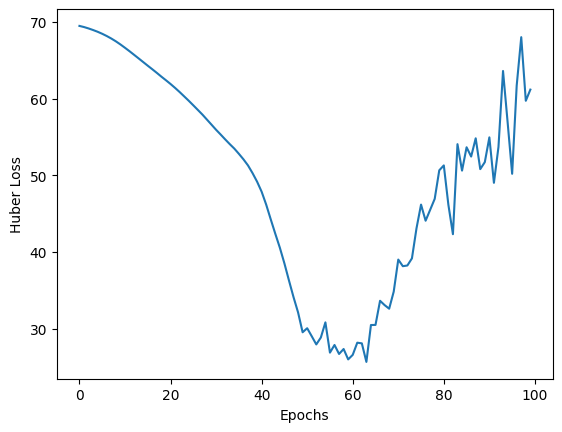

In [11]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')

### learning rate에 따른 loss 시각화 

학습률에 대한 손실 그래프를 로그 스케일로 표시합니다. 이 그래프를 사용하여 학습률이 적절한 범위로 조정되었는지 확인할 수 있습니다.  
plt.semilogx 함수를 사용하여 x 축을 로그 스케일로 표시합니다. 이 경우 x 축은 학습률(learning rate)이고, y 축은 손실(loss)입니다. 각 에포크에서 기록된 학습률과 손실을 사용하여 그래프를 그립니다.  
plt.axis 함수를 사용하여 그래프의 축 범위를 설정합니다. 여기서는 x 축(학습률)의 범위를 1e-7부터 1e-4까지로 설정하고, y 축(손실)의 범위를 20부터 70까지로 설정했습니다.  
최적의 학습률을 찾아 모델의 성능을 개선할 수 있습니다.

(1e-07, 0.0001, 20.0, 70.0)

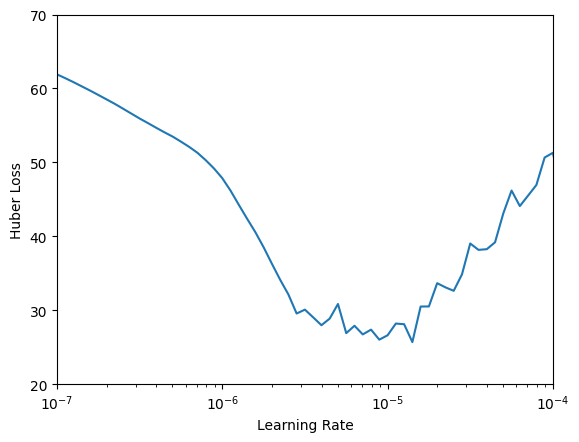

In [14]:
# 학습 과정에서 기록된 학습률(Learning Rate)과 손실(Loss) 값을 로그 스케일로 그래프에 표시합니다.
plt.semilogx(history.history['lr'], history.history['loss'])
plt.xlabel('Learning Rate') # x축에는 학습률을 표시합니다.
plt.ylabel('Huber Loss') # y축에는 Huber 손실 값을 표시합니다.

# 그래프의 x축과 y축 범위를 설정합니다. x축은 1e-7부터 1e-4까지, y축은 20부터 70까지로 설정합니다.
plt.axis([1e-7, 1e-4, 20, 70])

손실이 최소일 때의 학습률을 찾습니다.

np.array(history.history["loss"])를 사용하여 손실 값들을 NumPy 배열로 변환하고, np.min(history.history["loss"])를 사용하여 최소 손실 값을 찾습니다. 이 값을 비교하여 최소 손실 값이 발생하는 인덱스를 찾습니다.

np.array(history.history['lr'])를 사용하여 학습률 값들을 NumPy 배열로 변환하고, 앞에서 찾은 인덱스를 사용하여 최소 손실 값을 가지는 학습률을 선택합니다. 이렇게 찾은 학습률을 best_lr 변수에 저장합니다.

이렇게 찾은 최적의 학습률을 사용하여 모델의 성능을 개선할 수 있습니다.

In [16]:
# history.history["loss"] 배열에서 최소 손실 값과 같은 값들의 위치를 True, 아닌 경우 False로 하는 리스트 생성
idx = list(np.array(history.history["loss"]) == np.min(history.history["loss"]))

# 위에서 찾은 위치에 해당하는 학습률 값을 best_lr에 할당
best_lr = np.array(history.history['lr'])[idx]

# 최적의 학습률을 출력
best_lr

array([1.4125376e-05], dtype=float32)

### model re-train

최적의 learning rate를 이용하여 model retrain

In [17]:
model = create_model()

optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr[0], momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_ds, epochs=100)

Epoch 1/100
27/27 [==============================] - 2s 8ms/step - loss: 71.5901 - mae: 72.0882
Epoch 2/100
27/27 [==============================] - 0s 7ms/step - loss: 49.2098 - mae: 49.7082
Epoch 3/100
27/27 [==============================] - 0s 7ms/step - loss: 41.1529 - mae: 41.6461
Epoch 4/100
27/27 [==============================] - 0s 7ms/step - loss: 32.4260 - mae: 32.9170
Epoch 5/100
27/27 [==============================] - 0s 7ms/step - loss: 30.0648 - mae: 30.5619
Epoch 6/100
27/27 [==============================] - 0s 7ms/step - loss: 29.9112 - mae: 30.4054
Epoch 7/100
27/27 [==============================] - 0s 8ms/step - loss: 32.1974 - mae: 32.6929
Epoch 8/100
27/27 [==============================] - 0s 7ms/step - loss: 28.8159 - mae: 29.3141
Epoch 9/100
27/27 [==============================] - 0s 7ms/step - loss: 30.9391 - mae: 31.4328
Epoch 10/100
27/27 [==============================] - 0s 7ms/step - loss: 28.6421 - mae: 29.1361
Epoch 11/100
27/27 [===================

Text(0, 0.5, 'Huber Loss')

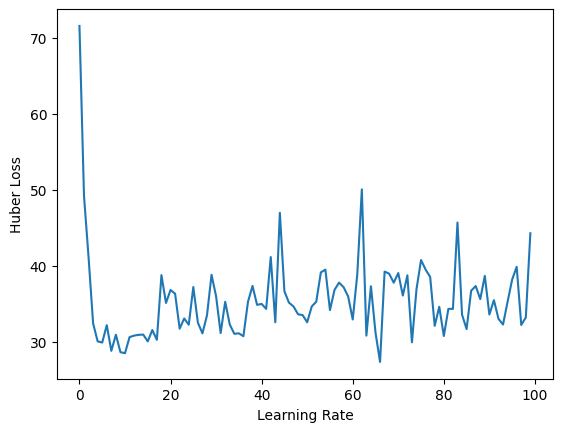

In [18]:
plt.plot(history.history['loss'])
plt.xlabel('Learning Rate') 
plt.ylabel('Huber Loss') 

테스트 데이터셋에 대한 예측을 수행합니다.

split_time부터 len(time_series)까지의 범위로 for 반복문을 수행하고, 이 때 현재 시점(time)에서 과거의 window_size 크기의 데이터를 선택합니다. 선택한 데이터를 모델의 입력 차원에 맞게 reshape하고, 이 데이터를 사용하여 모델을 통해 예측을 수행합니다.

예측된 결과는 prediction[0][0]에 저장되어 있습니다. 이 값을 forecast 리스트에 추가하여 예측 값을 저장하고, 반복문이 끝날 때까지 이 과정을 계속합니다.

이렇게 생성된 forecast 리스트는 테스트 데이터셋에 대한 모델의 예측 값들을 포함하고 있습니다.

In [19]:
forecast = []

for time in range(split_time, len(time_series)):
    prediction = model.predict(time_series[time-window_size: time].reshape(1, -1), verbose=0)
    forecast.append(prediction[0][0])
    
len(forecast)

50

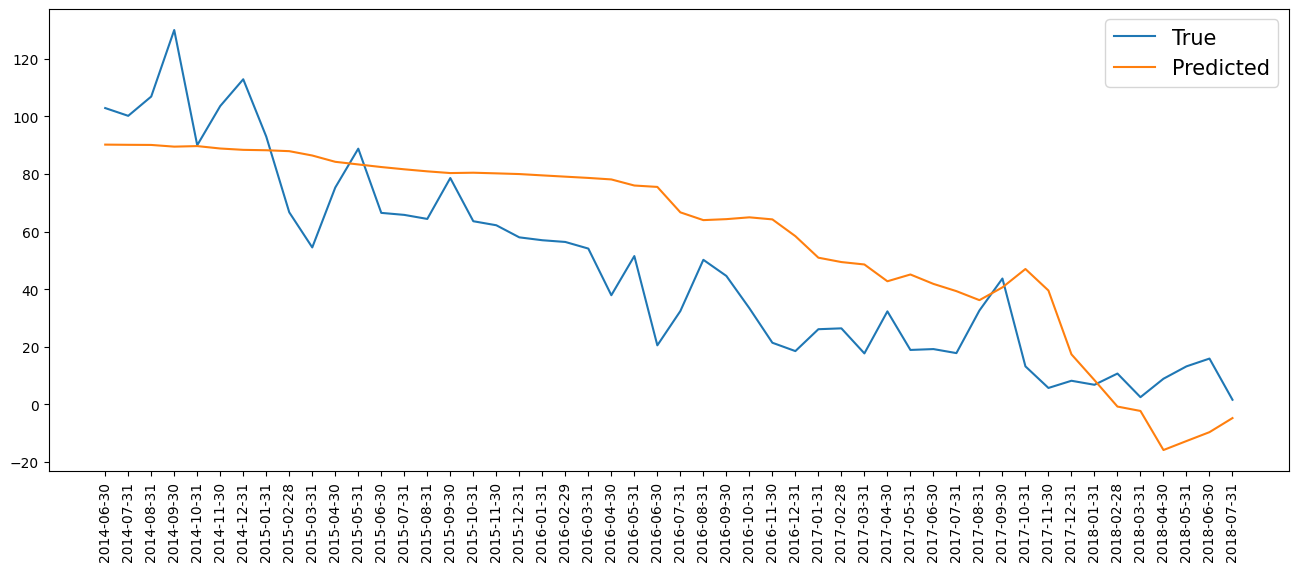

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(time_test, X_test, label='True')
plt.plot(time_test, forecast, label='Predicted')
plt.xticks(rotation=90)
plt.legend(fontsize=15)
plt.show()

In [21]:
print(tf.keras.metrics.mean_squared_error(X_test, forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(X_test, forecast).numpy())

558.5319
20.277542
